In [17]:
# This notebook has explorations of the missing and non-numeric values
# that need to be cleaned before running the graduation rate data through modeling.

# This code can be used as a prototype for the functions that clean the data 
# in the ingestion module.
import sys
import pandas as pd
import numpy as np
sys.path.append("..")
import ingestion.grad_rate as gr
from IPython import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [18]:
df = gr.make_gr_frame(year=2012)
print(df.columns)
dfsub = df[['NCESSCH','STNAM','SCHNAM','ALL','ALL_RATE']]

Index(['STNAM', 'NCESSCH', 'SCHNAM', 'ALL', 'ALL_RATE', 'MAM', 'MAM_RATE',
       'MAS', 'MAS_RATE', 'MBL', 'MBL_RATE', 'MHI', 'MHI_RATE', 'MTR',
       'MTR_RATE', 'MWH', 'MWH_RATE', 'CWD', 'CWD_RATE', 'ECD', 'ECD_RATE',
       'LEP', 'LEP_RATE'],
      dtype='object')


In [19]:
def conv_range_to_float(t: str):
    vals = t.split('-')
    if len(vals) == 2:
        val1,val2 = np.float64(vals)
        return round(val1/2.0 + val2/2.0, 0)
    else:
        return t

test_entries = "84-99", "1-2", "3", "GE50"
for i in test_entries:
    print(conv_range_to_float(i))

92.0
2.0
3
GE50


In [20]:
sum(dfsub.ALL.isna()), sum(dfsub.ALL_RATE.isna()), sum(dfsub.NCESSCH.isna())
sum(dfsub.NCESSCH == '.'), sum(dfsub.ALL == '.'), sum(dfsub.ALL_RATE == '.')
sum(dfsub.ALL_RATE == 'PS')

(0, 0, 0)

(0, 586, 0)

1304

In [21]:
def conv_range_to_float(t: str):
    vals = t.split('-')
    if len(vals) == 2:
        val1,val2 = np.float64(vals)
        return round(val1/2.0 + val2/2.0, 0)
    else:
        return t

def clean_all_rate(df : pd.DataFrame):
    # Drop schools with no value given for the number of total kids.
    df.loc[:,:] = df[df.ALL != "."]
    # Drop small schools that have less than 5 total students in their cohort because no rate is given for them.
    df.loc[:,:] = df[df.ALL_RATE != "PS"]
    df.dropna(subset=['NCESSCH', 'ALL','ALL_RATE'],inplace=True)
    # Prefixes are given for the graduation rates that mean "greater than", "less than", etc. to make it hard to identify
    # individual children when the cohorts are small. 
    # Strip off prefixes and use the range endpoint as an approximation for the grad rate.
    prefixes = ['GT','LT','GE','LE']
    colname = 'ALL_RATE'
    df.loc[:, colname] = df[colname].str.removeprefix('GE')
    df.loc[:, colname] = df[colname].str.removeprefix('LE')
    df.loc[:, colname] = df[colname].str.removeprefix('GT')
    df.loc[:, colname] = df[colname].str.removeprefix('LT')

    df.loc[:,'ALL_RATE2'] = df.ALL_RATE.transform(conv_range_to_float)

    df.loc[:,'ALL'] = pd.to_numeric(df.ALL)
    df.loc[:,'ALL_RATE2'] = pd.to_numeric(df.ALL_RATE2)
    
    df.loc[:,'ALL_RATE'] = df.ALL_RATE2
    df.drop(labels='ALL_RATE2',axis=1,inplace=True) 

    assert((sum(df.ALL == '.'), sum(df.ALL_RATE == 'PS')) == (0, 0))
    return df


/tmp/ipykernel_169649/138385160.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,:] = df[df.ALL != "."]
/tmp/ipykernel_169649/138385160.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,:] = df[df.ALL_RATE != "PS"]
/tmp/ipykernel_169649/138385160.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

,NCESSCH,STNAM,SCHNAM,ALL,ALL_RATE


<AxesSubplot:>

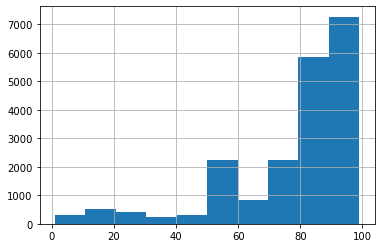

In [22]:
dfsub = clean_all_rate(dfsub)

dfsub[dfsub.ALL_RATE > 100]
dfsub.ALL_RATE.hist()

In [23]:
dfsub.dtypes

NCESSCH     float64
STNAM        object
SCHNAM       object
ALL           int64
ALL_RATE    float64
dtype: object

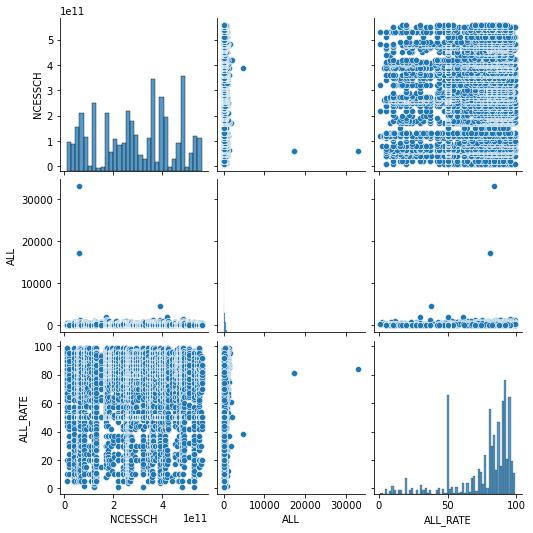

In [24]:
import seaborn as sns
sns.pairplot(dfsub)

In [25]:
# How many schools are in the cleaned datset per state?
dfsub.groupby('STNAM').count()

,NCESSCH,SCHNAM,ALL,ALL_RATE
STNAM,,,,
ALABAMA,373,373,373,373
ALASKA,156,156,156,156
ARIZONA,500,500,500,500
ARKANSAS,301,301,301,301
CALIFORNIA,1579,1579,1579,1579
COLORADO,420,420,420,420
CONNECTICUT,196,196,196,196
DELAWARE,53,53,53,53
DISTRICT OF COLUMBIA,39,39,39,39
